In [72]:
from nltk.tokenize import sent_tokenize

import ollama

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import pairwise_distances


from reco_systems.filter import filter_df
from reco_systems.llm import *
from reco_systems.CF_knn import *
from reco_systems.user_game_matrix import *
from reco_systems.evaluation import *
from reco_systems.text_filtering import *
from reco_systems.lemmatization import *
from reco_systems.embeds_utils import *

from sklearn.feature_extraction.text import CountVectorizer
from treetaggerwrapper import TreeTagger
from nltk.corpus import stopwords
from nltk import word_tokenize
import textwrap
from string import punctuation
from unicodedata import normalize
from unidecode import unidecode
from itertools import product


sns.set_theme()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)

rev_filter = rev_filter.assign(index=rev_filter.index)
rev_filter["Length"] = rev_filter["Comment body"].str.split().apply(len)

lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv")
#lemmas = lemmas[~lemmas["Lemma"].isna()]
corpus = construction_corpus(lemmas, 5000)
lemmas = lemmas[lemmas["Lemma"].isin(corpus)]

comments_lemmatized = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index()
rev_filter = rev_filter[rev_filter["index"].isin(comments_lemmatized["Comment line"])]
comments_lemmatized = comments_lemmatized.merge(rev_filter[["Game id", "User id", "index"]], left_on="Comment line", right_on="index")

rev_filter, _ = center_score(rev_filter)
users_means = rev_filter[["User id", "Rating"]].groupby("User id").mean().reset_index()

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


# Phrase embeddings with `BAAI/BG3`

### Sentence splitting

In [3]:
# rev_filter_embed = rev_filter.copy()

# # Unicode normalization
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].apply(lambda row : normalize("NFKC", row))

# # Replace extra caracters that served as a separation
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"\*{15,}", " ", regex=True)
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"-{10,}", " ", regex=True)

# # Add space after . or ? or ! for phrases 
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r'([.!?\)])(?=\S)', r'\1 ', regex=True)

# # replace /' by '
# rev_filter_embed.loc[:, "Comment body"] = rev_filter_embed["Comment body"].str.replace(r"\\{1,}'", r"'", regex=True)

# # Delete *** (more that 7 times) 
# rev_filter_embed["Phrases"] = rev_filter_embed["Comment body"].apply(sent_tokenize)
# rev_filter_embed = rev_filter_embed[["Game id", "User id", "index", "Phrases"]]
# rev_filter_embed = rev_filter_embed.explode("Phrases")

# # Delete phrases that contains only regex
# punc_regex = r"^[^\w\s]+$"
# rev_filter_embed = rev_filter_embed[~rev_filter_embed["Phrases"].str.match(punc_regex, na=False)]
# rev_filter_embed["Length"] = rev_filter_embed["Phrases"].str.split().apply(len)
# rev_filter_embed["Length"].sort_values().tail(10)
# rev_filter_embed.shape

### Embeddings

In [4]:
# # Embed separately 
# long_row = rev_filter_embed[rev_filter_embed["Length"] > 700]
# rev_filter_embed = rev_filter_embed.drop(long_row.index)

# from FlagEmbedding import BGEM3FlagModel

# model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

# phrases = rev_filter_embed["Phrases"].tolist()

# Time spent : 10h37min
# # Batch encode
# encoded = model.encode(phrases, batch_size=16, max_length=800, return_dense=True)

# encoded_long = model.encode(long_row["Phrases"].item(), max_length=2048, return_dense=True)

# embed = rev_filter_embed.assign(Embedding = list(encoded["dense_vecs"]))
# long_row["Embedding"] = [list(encoded_long["dense_vecs"])]
# embed = pd.concat([embed, long_row])
# # embed
# embed.to_parquet("../generated_data/comments_embed.parquet")

# Clustering phrases KMeans

- Positive -> 200 clusters
- Negative -> 250 clusters
- No separation -> 500 clusters

***
- Discard clusters where mean intra distance > 0.8
- ~~Discard clusters that have less than 10 phrases~~ 

### KMeans clustering on all comments (no pos/neg separation)

In [37]:
comments_embed = pd.read_parquet("../generated_data/comments_embed.parquet")
comments_embed = comments_embed[comments_embed["Phrases"].str.contains(r'[a-zA-Z]', regex=True)]
comments_embed = comments_embed.drop_duplicates(subset="Phrases", keep="first")
print(comments_embed.shape)

(591813, 6)


In [12]:
# embeds = np.array(comments_embed["Embedding"].tolist())
# distortions_means = []
# centroids_distances = []
# nb_clusters = np.arange(100, 1100, 100)[::-1]

# for n in nb_clusters:
#     print(n)
#     kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=1) 
#     kmeans.fit(embeds) 
#     print("Clustering done")

#     centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
#     print(centers.shape)

#     distances = np.linalg.norm(embeds - centers, axis=1)
#     print("Distances calculated")

#     distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
#     mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
#     distortions_means.append(mean_distortion)
    
#     centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
#     mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
#     centroids_distances.append(mean)


In [13]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ax1.plot(nb_clusters, distortions_means, marker='o')
# ax1.set_title("Mean distortion")
# ax1.set_xlabel("Number of clusters")
# ax1.set_ylabel("Mean distortion")

# ax2.plot(nb_clusters, centroids_distances, marker='o')
# ax2.set_title("Mean distance between clusters")
# ax2.set_xlabel("Number of clusters")
# ax2.set_ylabel("Mean distance")

# fig.suptitle("Clusters on all comments")

### $500$ Clusters

In [ ]:
# all_embeds = np.array(comments_embed["Embedding"].tolist())
# kmeans = MiniBatchKMeans(n_clusters=500, batch_size=1024, random_state=42, verbose=0) 
# kmeans.fit(all_embeds)

# centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
# distances = np.linalg.norm(all_embeds - centers, axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'assign'

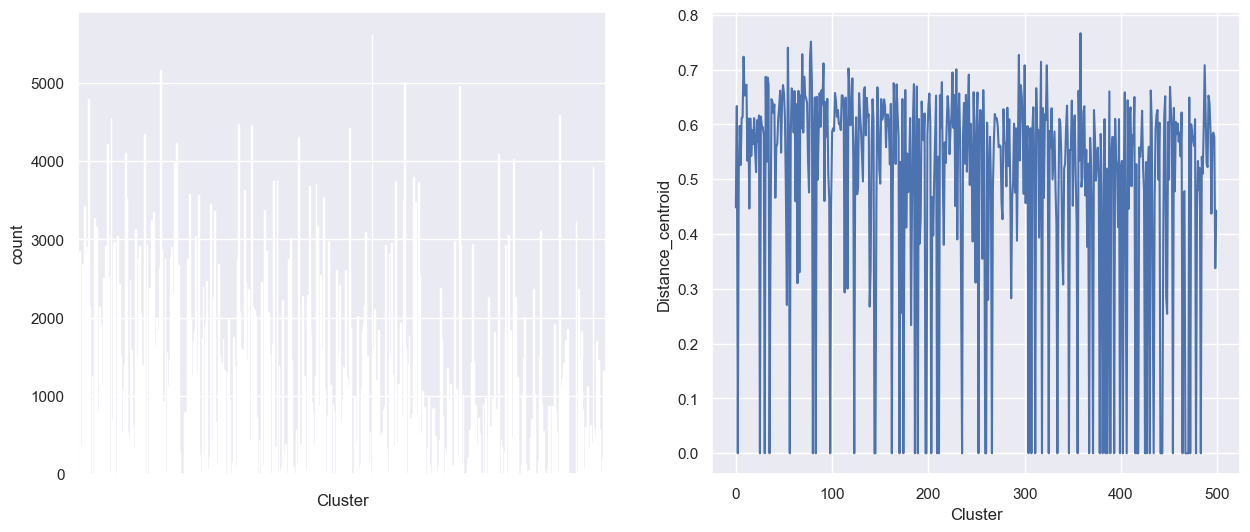

In [ ]:
# comments_clusters = comments_embed.assign(Cluster=kmeans.labels_, Distance_centroid=distances)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# count = comments_clusters["Cluster"].value_counts().reset_index()
# sns.barplot(comments_clusters["Cluster"].value_counts(), ax=ax1)
# ax1.set_xticklabels([])

# mean_dist = comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
# sns.lineplot(data=mean_dist, x="Cluster", y="Distance_centroid")

# comments_clusters = comments_clusters[comments_clusters["Cluster"].isin(mean_dist.loc[mean_dist["Distance_centroid"] < 0.7, "Cluster"])]
# #pos_comments_clusters = pos_comments_clusters[pos_comments_clusters["Cluster"].isin(count.loc[count["count"] >= 10, "Cluster"])]

# preserved_clusters = np.sort(comments_clusters["Cluster"].unique())
# all_centroids = kmeans.cluster_centers_[preserved_clusters]

In [ ]:
# .parquet contains already clean clusters (see above)
#comments_clusters = pd.read_parquet("../generated_data/comments_clusters.parquet") 
#comments_clusters = comments_clusters.drop_duplicates(subset="Phrases", keep="first")

### KMeans clustering (pos/neg separation)

In [6]:
rev_filter_pos = rev_filter[rev_filter["Rating"] >= 0]
rev_filter_neg = rev_filter[rev_filter["Rating"] < 0]
rev_filter_pos.shape, rev_filter_neg.shape

comments_embed_pos = comments_embed[comments_embed["index"].isin(rev_filter_pos["index"])]
comments_embed_neg = comments_embed[comments_embed["index"].isin(rev_filter_neg["index"])]
embeds_pos = np.array(comments_embed_pos["Embedding"].tolist())
embeds_neg = np.array(comments_embed_neg["Embedding"].tolist())

#### Positive

In [42]:
# distortions_means = []
# centroids_distances = []
# nb_clusters = np.arange(50, 450, 50)[::-1]

# for n in nb_clusters:
#     print(n)
#     kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=0) 
#     kmeans.fit(embeds_pos) 
#     print("Clustering done")

#     centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
#     print(centers.shape)

#     distances = np.linalg.norm(embeds_pos - centers, axis=1)
#     print("Distances calculated")

#     distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
#     mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
#     distortions_means.append(mean_distortion)
    
#     centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
#     mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
#     centroids_distances.append(mean)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ax1.plot(nb_clusters, distortions_means, marker='o')
# ax1.set_title("Mean distortion")
# ax1.set_xlabel("Number of clusters")
# ax1.set_ylabel("Mean distortion")

# ax2.plot(nb_clusters, centroids_distances, marker='o')
# ax2.set_title("Mean distance between clusters")
# ax2.set_xlabel("Number of clusters")
# ax2.set_ylabel("Mean distance")

# fig.suptitle("Clusters on positive comments")

#### $200$ clusters

In [7]:
kmeans = MiniBatchKMeans(n_clusters=200, batch_size=1024, random_state=42, verbose=0) 
kmeans.fit(embeds_pos)

centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
distances = np.linalg.norm(embeds_pos - centers, axis=1)

pos_comments_clusters = comments_embed_pos.assign(Cluster=kmeans.labels_, Distance_centroid=distances)

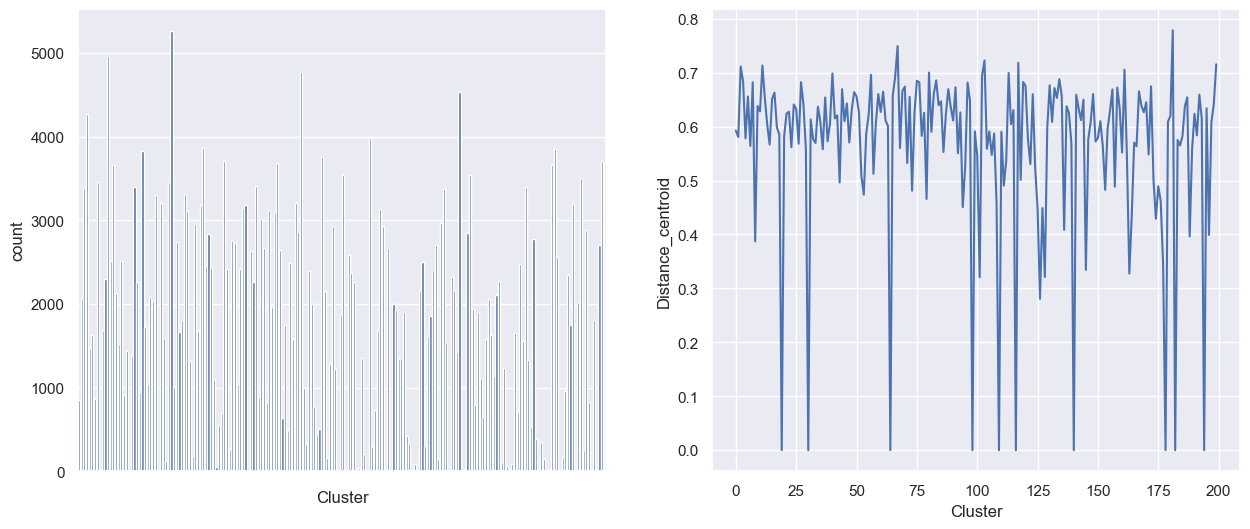

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

count = pos_comments_clusters["Cluster"].value_counts().reset_index()
sns.barplot(pos_comments_clusters["Cluster"].value_counts(), ax=ax1)
ax1.set_xticklabels([])

mean_dist = pos_comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
sns.lineplot(data=mean_dist, x="Cluster", y="Distance_centroid")

pos_comments_clusters = pos_comments_clusters[pos_comments_clusters["Cluster"].isin(mean_dist.loc[mean_dist["Distance_centroid"] < 0.7, "Cluster"])]
#pos_comments_clusters = pos_comments_clusters[pos_comments_clusters["Cluster"].isin(count.loc[count["count"] >= 10, "Cluster"])]

preserved_clusters_pos = np.sort(pos_comments_clusters["Cluster"].unique())
pod_centroids = kmeans.cluster_centers_[preserved_clusters_pos]

#### Negative comments

In [ ]:
# distortions_means = []
# centroids_distances = []
# nb_clusters = np.arange(50, 450, 50)[::-1]

# for n in nb_clusters:
#     print(n)
#     kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=0) 
#     kmeans.fit(embeds_neg) 
#     print("Clustering done")

#     centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
#     print(centers.shape)

#     distances = np.linalg.norm(embeds_neg - centers, axis=1)
#     print("Distances calculated")

#     distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
#     mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
#     distortions_means.append(mean_distortion)
    
#     centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
#     mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
#     centroids_distances.append(mean)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ax1.plot(nb_clusters, distortions_means, marker='o')
# ax1.set_title("Mean distortion")
# ax1.set_xlabel("Number of clusters")
# ax1.set_ylabel("Mean distortion")

# ax2.plot(nb_clusters, centroids_distances, marker='o')
# ax2.set_title("Mean distance between clusters")
# ax2.set_xlabel("Number of clusters")
# ax2.set_ylabel("Mean distance")

# fig.suptitle("Clusters on negative comments")

#### $250$ Clusters

In [9]:
kmeans = MiniBatchKMeans(n_clusters=250, batch_size=1024, random_state=42, verbose=0) 
kmeans.fit(embeds_neg)

centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
distances = np.linalg.norm(embeds_neg - centers, axis=1)

neg_comments_clusters = comments_embed_neg.assign(Cluster=kmeans.labels_, Distance_centroid=distances)

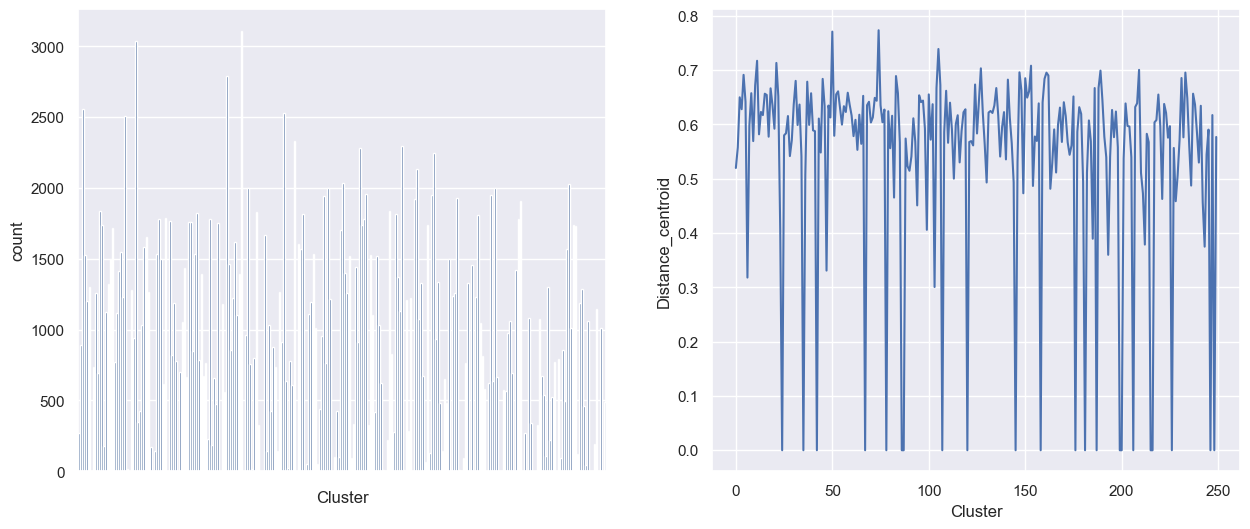

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

count = neg_comments_clusters["Cluster"].value_counts().reset_index()
sns.barplot(neg_comments_clusters["Cluster"].value_counts(), ax=ax1)
ax1.set_xticklabels([])

mean_dist = neg_comments_clusters.groupby("Cluster")["Distance_centroid"].mean().reset_index()
sns.lineplot(data=mean_dist, x="Cluster", y="Distance_centroid")

neg_comments_clusters = neg_comments_clusters[neg_comments_clusters["Cluster"].isin(mean_dist.loc[mean_dist["Distance_centroid"] < 0.7, "Cluster"])]
#neg_comments_clusters = neg_comments_clusters[neg_comments_clusters["Cluster"].isin(count.loc[count["count"] >= 10, "Cluster"])]
neg_comments_clusters

preserved_clusters_neg = np.sort(neg_comments_clusters["Cluster"].unique())
neg_centroids = kmeans.cluster_centers_[preserved_clusters_neg]

In [ ]:
distortions_means = []
centroids_distances = []
nb_clusters = np.arange(100, 1100, 100)[::-1]

for n in nb_clusters:
    print(n)
    kmeans = MiniBatchKMeans(n_clusters=n, batch_size=1024, random_state=42, verbose=1) 
    kmeans.fit(embeds) 
    print("Clustering done")

    centers = np.take_along_axis(kmeans.cluster_centers_, kmeans.labels_.reshape(-1, 1), axis=0)
    
    print(centers.shape)

    distances = np.linalg.norm(embeds - centers, axis=1)
    print("Distances calculated")

    distances = pd.DataFrame({"Distance_centroid": distances, "Cluster": kmeans.labels_})
    mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
    distortions_means.append(mean_distortion)
    
    centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
    mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
    centroids_distances.append(mean)


# Quantative evaluation 

In [11]:
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_dist_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")

users_table = users_table.to_frame().reset_index().rename(columns={"index":"User index"})
games_table = games_table.to_frame().reset_index().rename(columns={"index":"Game index"})

pos_comments_clusters = pos_comments_clusters.merge(users_table, on="User id").merge(games_table, on="Game id")
neg_comments_clusters = neg_comments_clusters.merge(users_table, on="User id").merge(games_table, on="Game id")

## Pos / neg separation

### Note : Shannon entropy ponderation
Here, $p_k$ for each cluster is calculated as a percentage of users comments 
- High entropy -> cluster is more generic
- Low entropy -> cluster is more specific

In [71]:
# pos_clusters_weights = cluster_weight_count(pos_comments_clusters)
# neg_clusters_weights = cluster_weight_count(neg_comments_clusters)
# np.random.seed(1)
# bigrams, unigrams = [], [] 
# users = rev_filter.groupby("User id")["Game id"].count().sort_values().tail(50).index
# print(users)

# for user in users:
#     print(user)
#     b, u = eval_embeddings(user, matrix_ratings, mask_ratings, users_table, games_table, 
#                            cos_dist_matrix, 40, users_means, pos_comments_clusters, neg_comments_clusters, 
#                            pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids, comments_lemmatized, lemmas, weight_type="count")
#     bigrams.append(b)
#     unigrams.append(u)
#     print("-------------------------------")

0 0
0 1
1 0
1 1


Text(0.5, 1.0, 'Count ponderation')

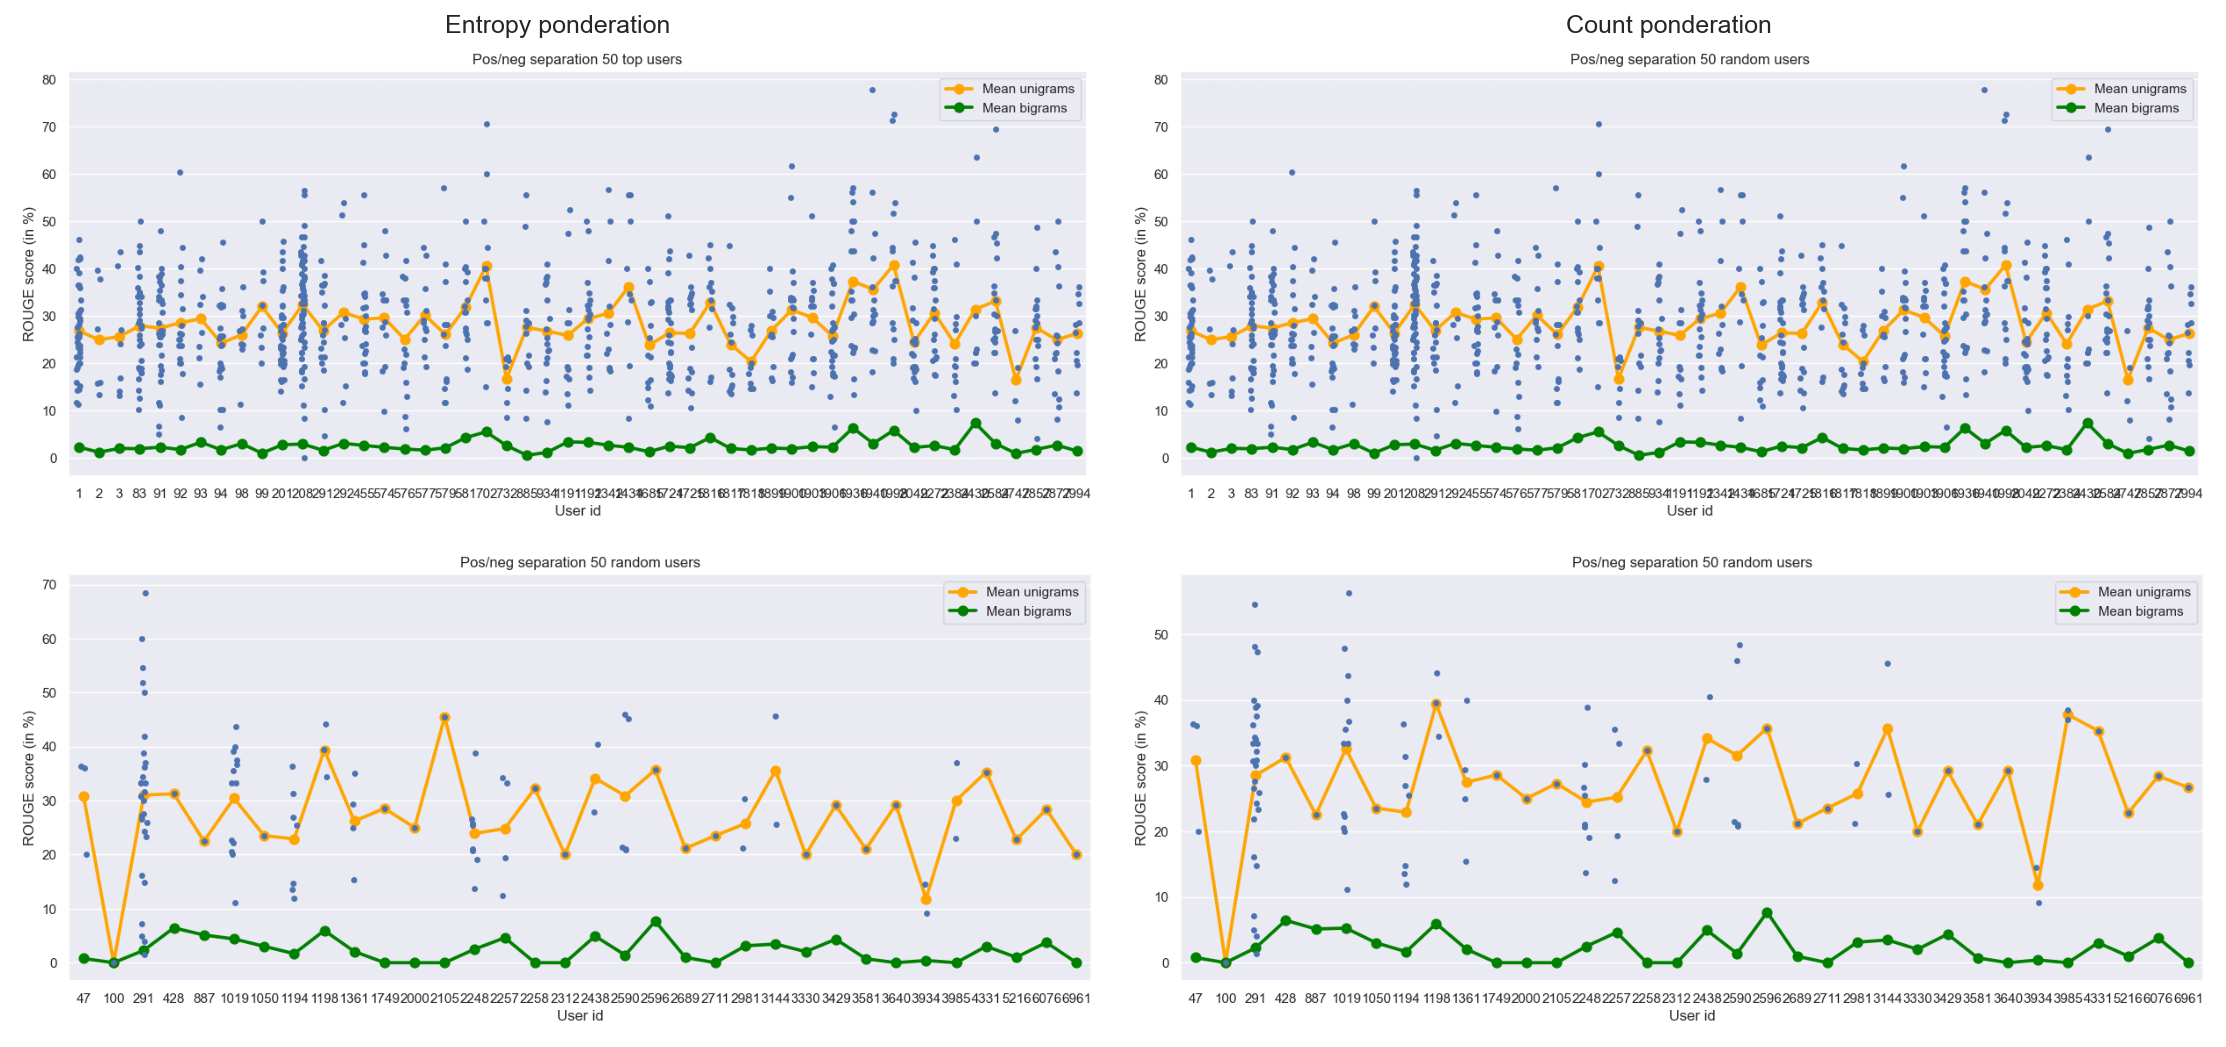

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), dpi=150)
folder = "../generated_data/embeds_eval"
im00, im10 = plt.imread(f"{folder}/entropy/pos_neg_top.png"), plt.imread(f"{folder}/entropy/pos_neg_random.png")
im01, im11 = plt.imread(f"{folder}/count/pos_neg_top.png"), plt.imread(f"{folder}/count/pos_neg_random.png")
images = [im00, im01, im10, im11]

for i, j in product(range(2), repeat=2):
    print(i, j)
    axes[i, j].imshow(images[i * 2 + j])
    axes[i, j].set_axis_off()
plt.tight_layout()

axes[0, 0].set_title("Entropy ponderation")
axes[0, 1].set_title("Count ponderation")

## No pos/neg separation

Text(0.5, 1.0, 'Count ponderation')

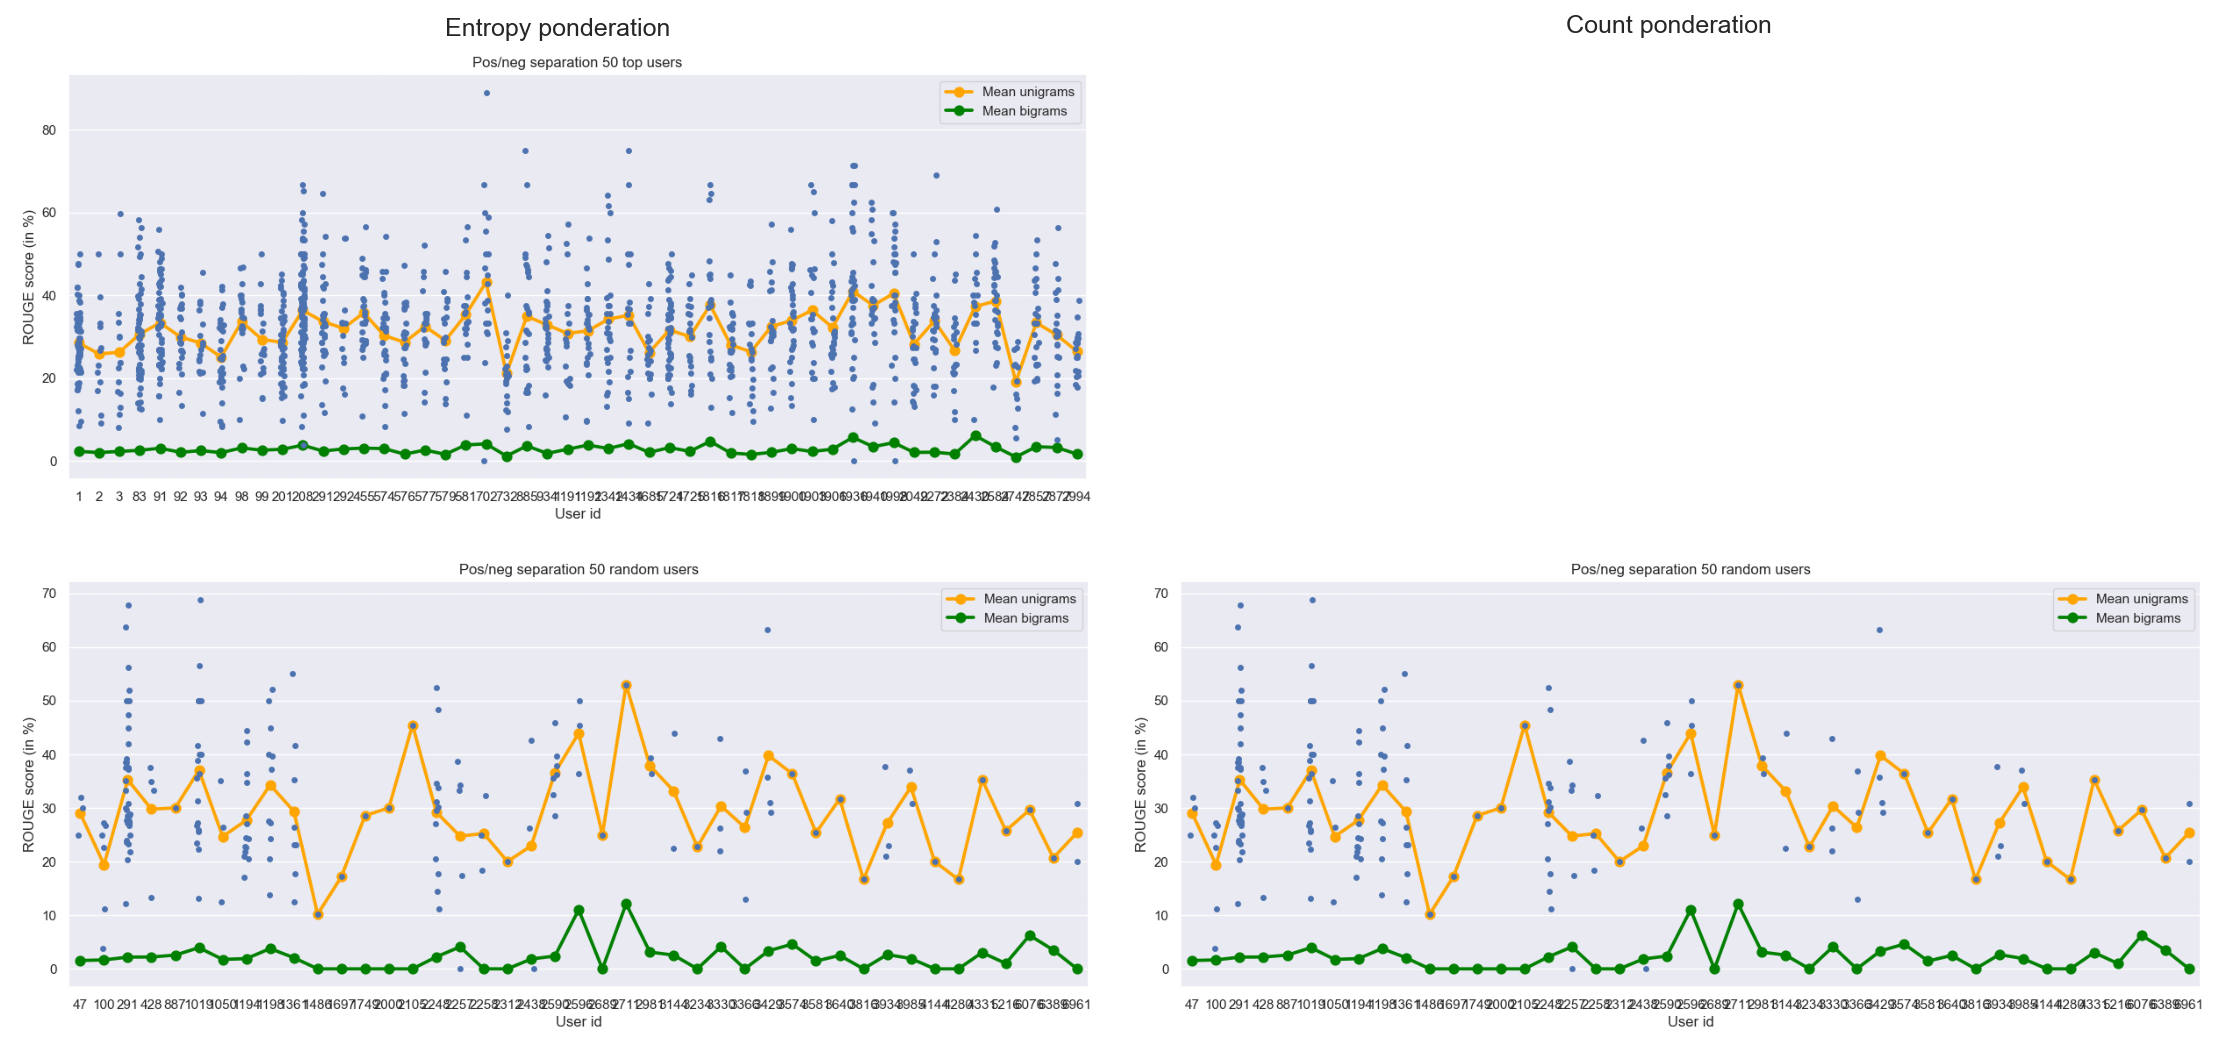

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), dpi=150)
folder = "../generated_data/embeds_eval"
im00, im10 = plt.imread(f"{folder}/entropy/all_top.png"), plt.imread(f"{folder}/entropy/all_random.png")
im11 = plt.imread(f"{folder}/count/all_random.png")
images = [im00, im01, im11]

for i, j in product(range(2), repeat=2):
    axes[i, j].set_axis_off()

axes[0, 0].imshow(images[i * 2 + j])
axes[1, 0].imshow(images[i * 2 + j])
axes[1, 1].imshow(images[2])
plt.tight_layout()

axes[0, 0].set_title("Entropy ponderation")
axes[0, 1].set_title("Count ponderation")

# Qualitative analysis

## Pos/neg separation

**User 0, Game 9146**

In [28]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 0) & (rev_filter["Game id"] == 9146)]["Comment body"].item(), width=100))

Très bien vu, Monsieur Sing ! Depuis votre console de Cap Canaveral, vous avez fort bien réussi à
marier le jeu de plis et le jeu coopératif. Il faut aimer les jeux de plis, certes. Mais pour ceux
qui n'aiment pas, l'aspect coopératif / puzzle-game pourrait prendre le dessus. Il faut aimer les
jeux coopératifs, d'accord. Mais pour ceux qui n'aiment pas, cela reste un vrai jeu de plis avec une
forme d'annonce. Au lieu d'avoir le "cul entre deux chaises", l'alliance renforce la somme des deux
aspects. Il faut même parfois se retenir, comme vous le diront les "ultras d'Hanabi", de ne pas
soulever un sourcil ou de s'exclamer d'un "OOOuuuh oui, trop bien !" lorsqu'un pli se passe comme
vous l'aviez prévu ! Parce que, qu'on le veuille ou non, ce sont des communications qui donnent des
infos supplémentaires simplifiant potentiellement la teneur du défi. Pourtant quel délice de vivre
entre amis ces regards lourds de sens, mais potentiellement incompréhensible, puisque l'informations
n'est que 

**All $3$ similar clusters**

In [29]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 0, 9146
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
game 9146 number of similar users comments 40 n clusters 3 phrases per cluster 1 1
Nb tokens: 281
Voici une possible commentaire sur le board game :

"Je pense que nous avons trouvé un trésor ! 'Il va falloir agrandir la capsule' pour que nous
puissions exploiter toutes les possibilités de jeu, car 'il va alors falloir s'étendre' dans les
différents plans d'action. En tout cas, il faudra 'faire avec' une certaine dose de stratégie et de
ruse, car c'est un peu 'ruser' pour gagner contre ses adversaires. Mais en fin de compte, ce jeu est
vraiment 'très malin', avec des mécanismes qui vous feront 'se creuser les méninges' pour comprendre
comment jouer correctement. C'est un excellent exemple du genre de jeu qui va faire entrer encore
plus de monde dans le monde merveilleux du jeu de société moderne, où la coopération et la
compétition se mélangent pour créer une expérience unique. Et avec ses missions à remplir et son
système de pli ul

**User 1, Game 3370**

In [30]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 1) & (rev_filter["Game id"] == 3370)]["Comment body"].item(), width=100))

De superbes illustrations pour un jeu de collection matinée de scopa et de contrats. Vous prenez des
cartes, plusieurs cartes, vous en remettez au centre de la table, vous en ajoutez de la pioche, vos
voisins s'en emparent mais vous laissent autre chose. On essaie de remplir les contrats en
planifiant mais surtout en s'adaptant et c 'est assez chaotique. Ca se joue vite, c'est beau. Il
vaut mieux être le max pour jouer, c'est plus tendu. Sans être le jeu de de l'année, il fait le taf.


**All $3$ similar clusters**

In [37]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 1, 3370
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
game 3370 number of similar users comments 30 n clusters 3 phrases per cluster 1 Nb of selected phrases 15
1
Nb tokens: 513
Voici une possible commentaires du joueur :

"Sans être inintéressant, ce jeu fait son office. Un peu inattendu, mais il me semble que c'est
justement cela qui me réjouit ! Il distraie, mais on joue dans son coin sans enthousiasme débordant.
Je pense que c'est un peu comme ça : Inutile de gonfler à dessein, ce jeu reste une distraction très
honnête, de courte durée mais toujours agréable.

Un jeu qui se laisse jouer sans non plus être sensationnel, mais qui a un charme discret. Un jeu
sans grande prétention, auxquel on ne jouera pas pendant des heures mais qui permet de se détendre
de temps en temps, si on en abuse pas. Je me suis laissé prendre par cela, et c'est amusant !

Au final le jeu ne soulève pas un enthousiasme démesuré mais se révèle être un divertissant
occasionnel honnête. Pourquoi ? Parce que il e

**User 1765, Game 5723**

In [38]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 1725) & (rev_filter["Game id"] == 5723)]["Comment body"].item(), width=100))

Bon, je ne vais pas m’étaler des heures sur ce monument, la littérature ne manque pas. Pour ceux qui
aiment les tensions, le bluff dans les enchères, la prise de tête au troisième degré (je pense qu’il
pense que j’ai peut être pensé ça) et l’optimalisation, sachez que ce jeu est fait pour vous. Note
sur l’extension présentée dans l’édition d’Ystari avec les personnages supplémentaires. Je n’y ai
joué qu’une fois mais ce sera la seule : ca alourdit sans réellement enrichir et ça brouille les
pistes.


**All $12$ similar clusters**

In [31]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 1725, 5723
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
Init 12
game 5723 number of similar users comments 150 n clusters 12 phrases per cluster 1 Nb of selected phrases 12
1
Nb tokens: 502
Voici une possible commentaires pour un commentaire sur le jeu :

"Je me suis réuni avec 4 néophytes et 1 joueur expérimenté, qui en profitant de son expérience a
largement gagné. Le matériels sont de qualité, la règle est simple mais on joue un peu chacun dans
son coin.

En début de partie, lors de la phase enchères, les cartes prestige et recrutement ne servent à rien,
donc soit on les prend pour plus tard sans trop savoir si on en aura besoin, soit on se bat avec les
autres pour récupérer des saltimbanques et des architectes, et des éléments de décors. Et vers la
fin, nous nous jeteons dessus !

Je dois dire que je préfère Colosseum (du même auteur) parce que le thème est plus fun, la partie
échange rend le jeu plus convivial, la durée de la partie est mieux pensée et l'anticipation des
prochains t

**User 1725, Game 9348**

In [34]:
print(textwrap.fill(rev_filter[(rev_filter["User id"] == 1725) & (rev_filter["Game id"] == 9348)]["Comment body"].item(), width=100))

Soyons clairs : vous ne serez pas bluffés par le mécanisme, simplissime et directement emprunté à un
jeu comme Uppsala. Par contre, le jeu est très agréable à pratiquer et rentre dans la catégorie des
jeux dont on ne se souvient pas qui a gagné dès le lendemain :-) Ce qui est fun c'est d'estimer
l'âge de ces découvertes et de voir à quel point on peut se planter ! Les illustrations sont très
belles et leur homogénéité empêche qu'on puisse se faire une idée grâce au style, pas mal vu. Par
contre, les cartes étant tellement petites on en profite pas becoup et surtout il n'y a aucune info
sur les inventions ! Même dans le fictionnaire ils ont été capables de rajouter quelques lignes de
textes qui divertissent et/ou rendent moins con. Dommage que ce ne soit pas le cas ici.La
rejouabilité n'est pas énorme non plus, à moins de laisser passer systématiquement beaucoup de temps
entre les parties. Ca sent l'extension prévue avant même la sortie du jeu :-(


**Choose clusters based on entropy 50/50**

In [35]:
pos_clusters_weights = cluster_weight_entropy(pos_comments_clusters)
neg_clusters_weights = cluster_weight_entropy(neg_comments_clusters)

user, game = 1725, 9348
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="entropy")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
Init 22
game 9348 number of similar users comments 220 n clusters 22 phrases per cluster 1 Nb of selected phrases 16
1
Nb tokens: 341
Voici une possible commentaire de user sur un board game en français :

"Même si les dates à retrouver sont très précises, dès 4 ou 5 parties jouées disparait la surprise
de l'époque de certaines découvertes. De racheter des cartes pour y rejouer, pas nécessairement. Il
n'en reste que le jeu est plaisant à jouer, simple d'accès et assez rapide. L'idée en soi n'est pas
bête, mais ça me fait chôur... Vous pouvez y jouer n'importe où, comme une terrasse de café par
exemple. On pourrait dire qu'il est sorti occasionnellement, cela permet d'oublier les cartes. Je ne
vois pas du tout le ressort ludique du jeu, c'est un peu étrange. Mais on peut s'interroger sur la
rejouabilité au-delà d'une vingtaine de parties, et après quelques parties vous avez fait le tour
des cartes et vous n'avez plus envie d'y jouer.

**Choose clusters based on count 50/50**

In [36]:
pos_clusters_weights = cluster_weight_count(pos_comments_clusters)
neg_clusters_weights = cluster_weight_count(neg_comments_clusters)

user, game = 1725, 9348
phrases = eval_embeddings(user, matrix_ratings, mask_ratings, 
                                users_table, games_table, cos_dist_matrix, 
                                40, users_means, pos_comments_clusters, neg_comments_clusters,
                                pos_clusters_weights, neg_clusters_weights, pod_centroids, neg_centroids,
                                comments_lemmatized, lemmas, specific_game=game, weight_type="count")

print("Nb of selected phrases", phrases.shape[0])

phrases = phrases.assign(Batch=assign_batch_number(phrases, 2300))
phrases_batched = phrases.groupby("Batch")["Phrases"].apply("\n ".join).tolist()
response = call_model_by_batch(phrases_batched, "combine_phrases")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Correct predicted ratings neg : 1, pos : 0 (1 hidden)
Init 22
game 9348 number of similar users comments 220 n clusters 22 phrases per cluster 1 Nb of selected phrases 16
1
Nb tokens: 302
Voici une possible combinaison des phrases pour générer un commentaire sur un board game :

"Je trouve que ce jeu est instructif et parfois étonnant, mais il n'en reste que le jeu est plaisir
à jouer, simple d'accès et assez rapide. La bonne idée en soi n'est pas bête, mais cela me fait
choker un peu. Vous pouvez y jouer n'importe où, certes ! On pourrait dire qu'il est un sortir
occasionnel, ce qui permet d'oublier les cartes et lui donner une touche de mystère. Mitigé, c'est
tout de même un jeu rapide également. Je ne vois pas du tout le ressort ludique du jeu, mais on peut
s'interroger sur la rejouabilité au-delà d'une vingtaine de parties. On sait ou pas ! Mais en fin de
compte, je pense que l'auteur est sympathique et a réussi à créer un petit choix fort agréable. Bien
que je n'en fasse pas un ac